# Z.PIEŃKOSZ - Lending Club - cześc 2

### DALSZA OBRÓBKA DANYCH - usunięcie odstających wartości

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
# wczytanie pliku z danymi obrobionymi w pierwszej części
ldskrn = pd.read_csv('ldskrn.csv')

In [3]:
ldskrn.shape

(42529, 38)

In [4]:
ldskrn.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'loan_status',
       'dti', 'delinq_2yrs', 'fico', 'wiek_kr', 'inq_last_6mths', 'pub_rec',
       'revol_bal', 'total_acc', 'pub_rec_bankruptcies', 'loan_inc_ratio',
       'inst_inc_ratio', 'term_60', 'grade_2', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'verification_status_2', 'verification_status_3',
       'purpose_num_1', 'purpose_num_2', 'purpose_num_3', 'purpose_num_4',
       'purpose_num_5', 'purpose_num_6', 'purpose_num_7', 'purpose_num_8',
       'purpose_num_9', 'purpose_num_10', 'purpose_num_11', 'purpose_num_12',
       'purpose_num_13'],
      dtype='object')

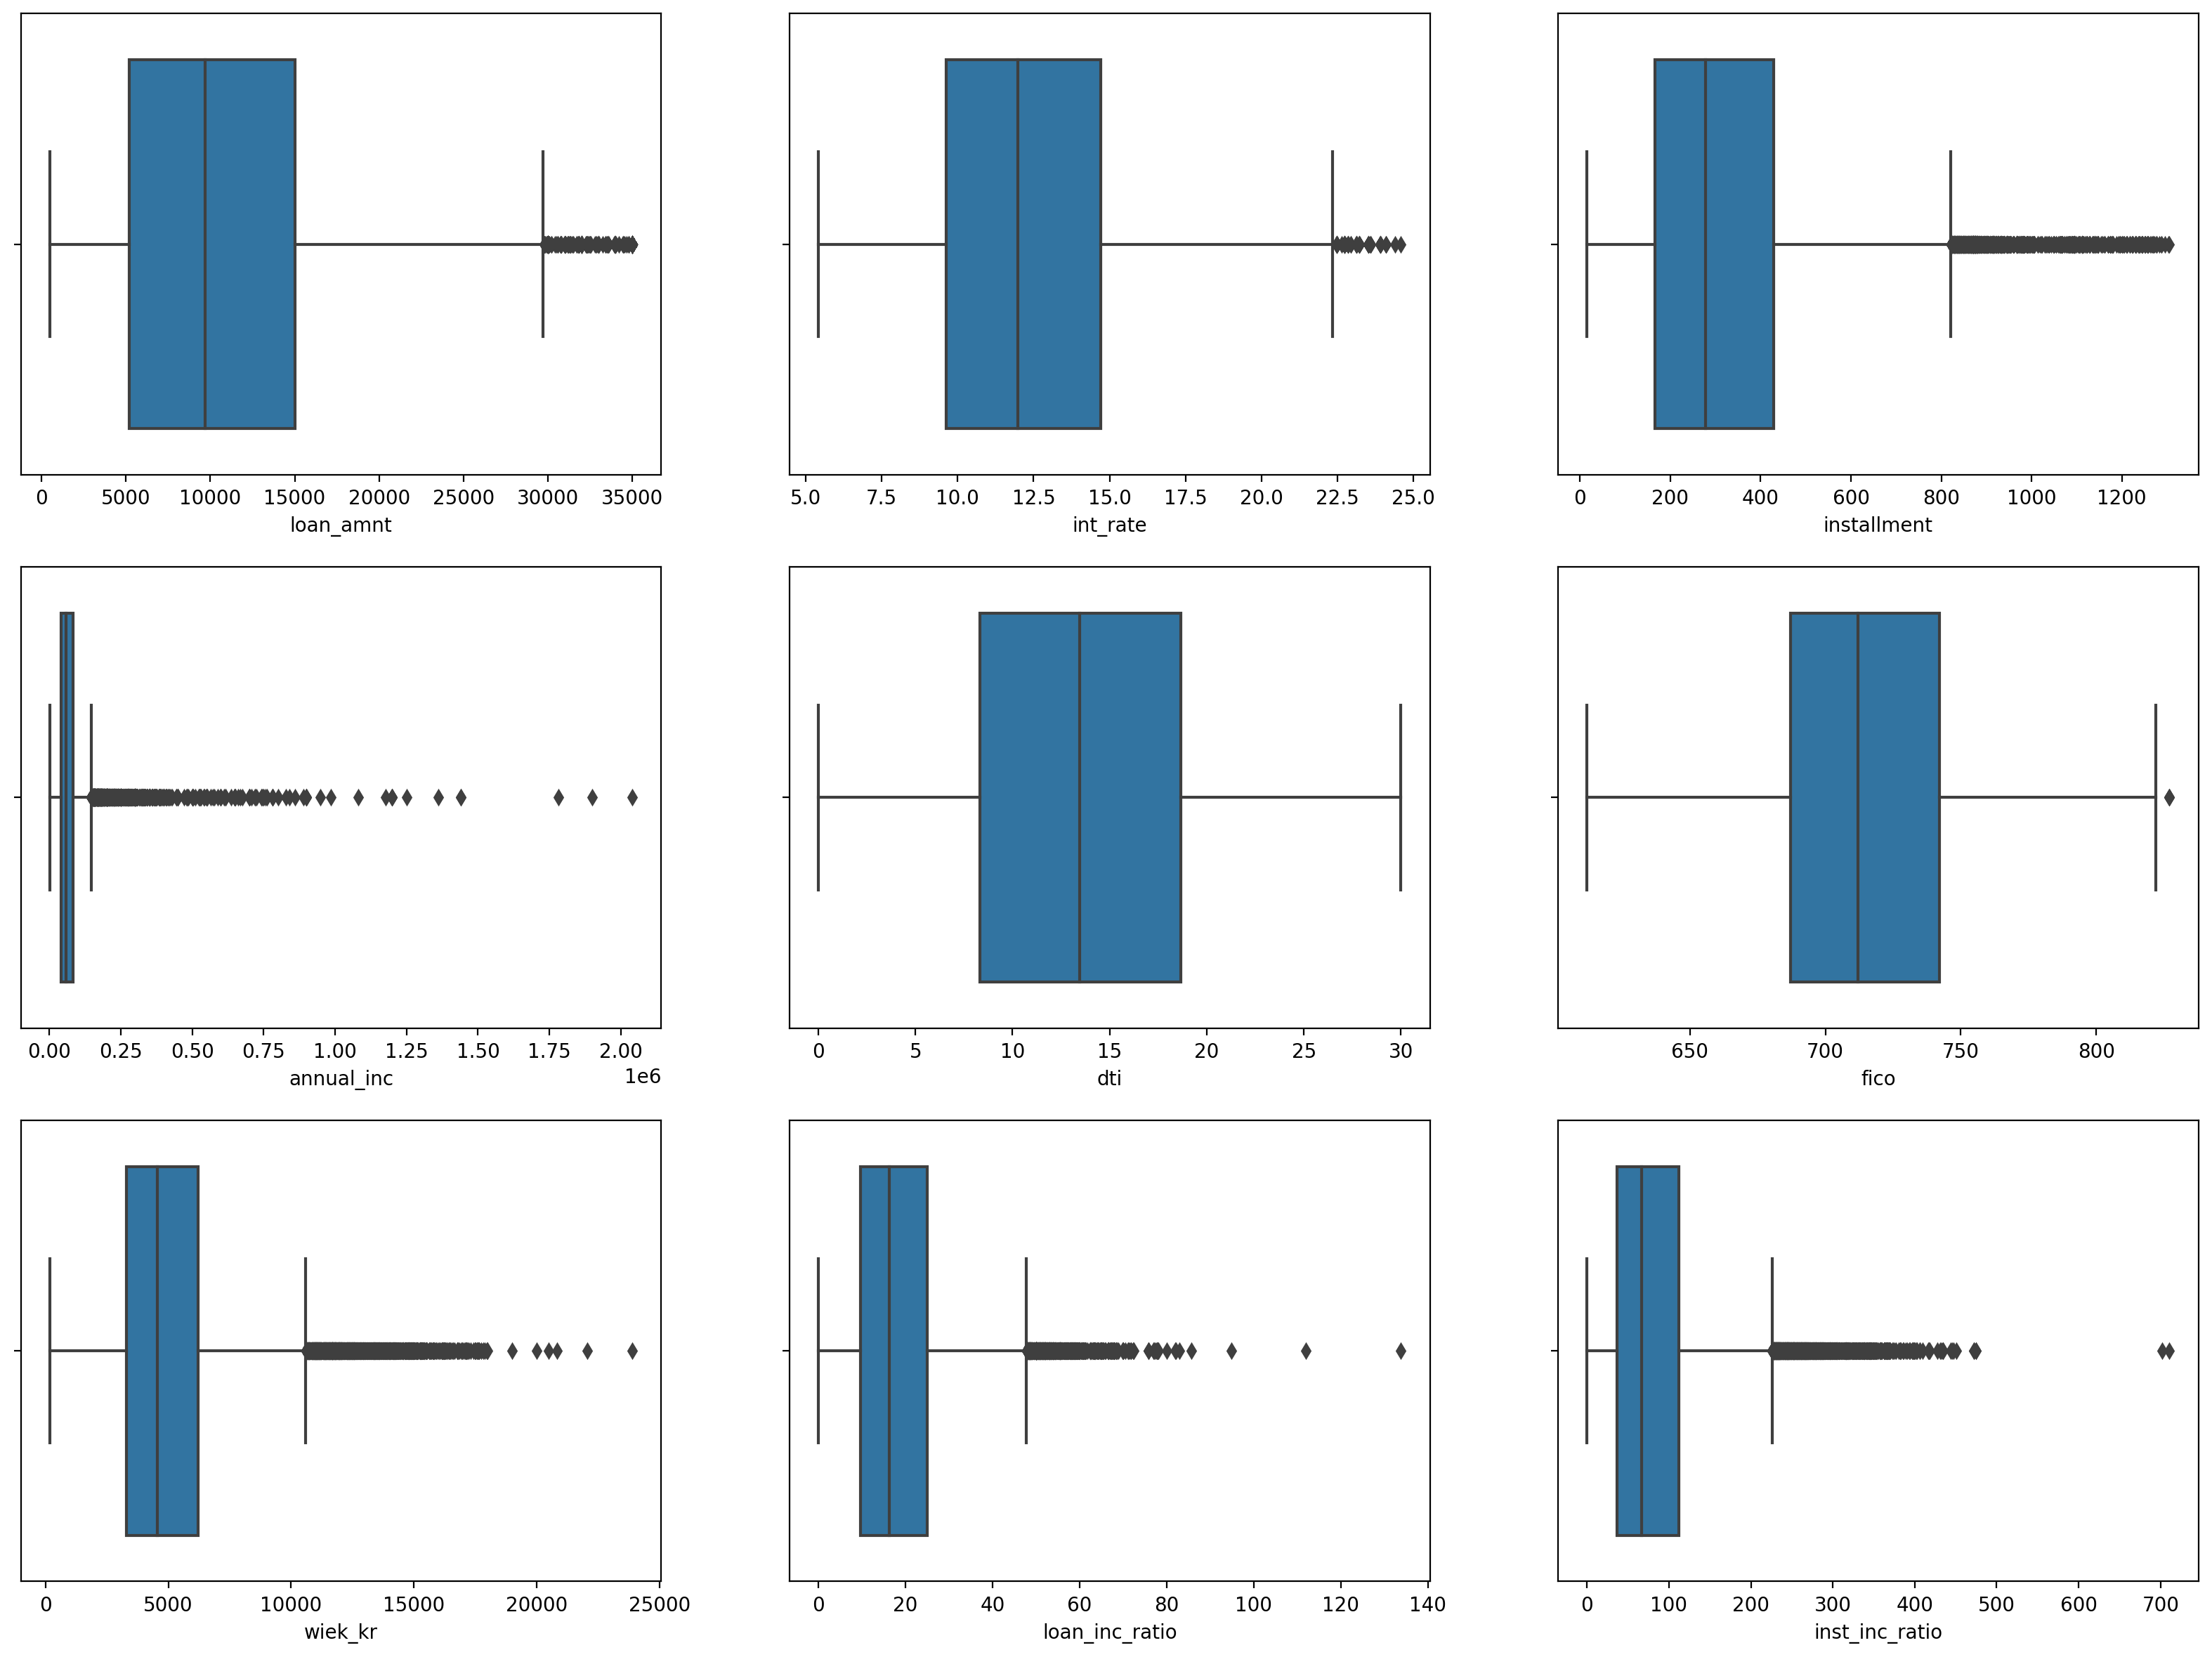

In [5]:
# sprawdzenie wizualne wartości odstających (outlierów)
plt.figure(figsize=(20,20), dpi=200)
plt.subplot(4,3,1)
sns.boxplot(x = 'loan_amnt', data = ldskrn)
plt.subplot(4,3,2)
sns.boxplot(x = 'int_rate', data = ldskrn)
plt.subplot(4,3,3)
sns.boxplot(x = 'installment', data = ldskrn)
plt.subplot(4,3,4)
sns.boxplot(x = 'annual_inc', data = ldskrn)
plt.subplot(4,3,5)
sns.boxplot(x = 'dti', data = ldskrn)
plt.subplot(4,3,6)
sns.boxplot(x = 'fico', data = ldskrn)
plt.subplot(4,3,7)
sns.boxplot(x = 'wiek_kr', data = ldskrn)
plt.subplot(4,3,8)
sns.boxplot(x = 'loan_inc_ratio', data = ldskrn)
plt.subplot(4,3,9)
sns.boxplot(x = 'inst_inc_ratio', data = ldskrn)
plt.show()

In [6]:
# najbardziej problematyczne są outliery w kolumnach 'annual_inc' i 'wiek_kr'
## usuniemy w nich outliery oddalane o więcej niż 3 odchylenia standardowe
z = np.abs(stats.zscore(ldskrn[['annual_inc', 'wiek_kr']]))

In [7]:
#print(z)

In [8]:
#print(np.where(z>3))

In [9]:
ldskrn.shape

(42529, 38)

In [10]:
ldskrn_outliers_removed = ldskrn[(z<3).all(axis=1)]

In [11]:
ldskrn_outliers_removed.shape
# mamy ok 1000 mniej obserwacji czyli ok 2,5% ostatniego zbioru, a więc strata nie jest duża

(41495, 38)

In [12]:
# utworzenie pliku z usuniętymi outlierami
ldskrn=ldskrn_outliers_removed

In [13]:
# Dzielenie danych na etykiety i atrybuty
x = ldskrn.drop(['loan_status'], axis = 1)
y = ldskrn['loan_status']

In [14]:
x.shape, y.shape

((41495, 37), (41495,))

# 4a. KLASTERYZACJA TRZEMA METODAMI Z KOMPRESJĄ PCA

In [15]:
# dla celów wizualizaji klasteryzacji, kompresja na 2 komponenty
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2, svd_solver = 'full')
x_pca = pca_2d.fit_transform(x)
x_pca = pd.DataFrame(x_pca, columns=['c1', 'c2'], index=x.index)
x_pca.head()

,c1,c2
0,-40087.332803,10777.060334
1,-37781.499378,-2495.692104
2,-54531.228166,3421.720969
3,-17617.693384,-3572.494410
4,17155.150582,9406.671858


In [16]:
x_pca.shape

(41495, 2)

In [17]:
# skalowanie danych
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_pca)
x_pca_sc = scaler.transform(x_pca)
x_pca_df = pd.DataFrame(data=x_pca_sc, index=x_pca.index, columns=x_pca.columns)

In [18]:
# dla przyspieszenia obliczeń ograniczymy zbiór do próbki 1000
x_pca = x_pca_df.sample(1000, random_state=42)

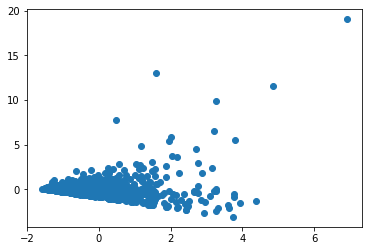

In [19]:
# wizualizacja zbioru przed podziałem na klastry
plt.scatter(x_pca.c1, x_pca.c2)

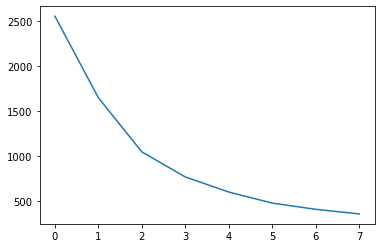

In [20]:
#wykorzystamy obliczenia ilości klastrów metodą łokcia dla k-means
from sklearn.cluster import KMeans
ssd = [] # Sum of squared distances
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(x_pca.iloc[:,0:2])
    ssd.append(kmeans.inertia_) #Sum of squared distances
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [21]:
# na podstawie metody łokcia mozna przyjąć 4 klastry do dalszej wizualizacji

In [22]:
# KLASTERYZACJA HIERRARCHICZNA

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [24]:
w_mergings = linkage(x_pca, method='ward', metric='euclidean')

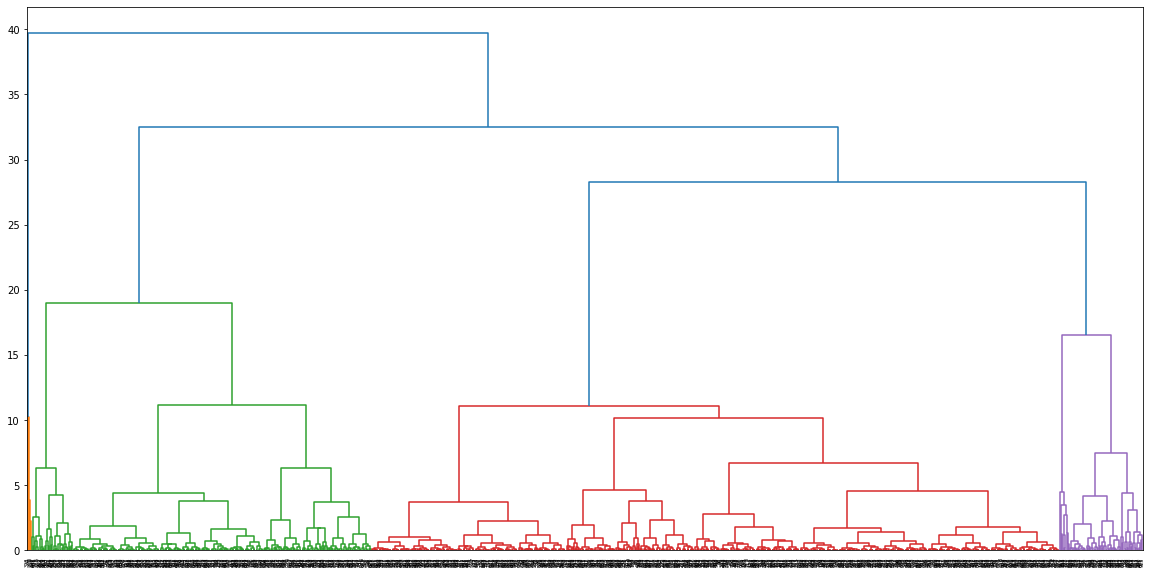

In [25]:
# UWAGA rysuje się ok 2 minuty
# dengrogram, metoda ward linkage
fig = plt.figure(figsize=(20, 10))
dendrogram(w_mergings)
plt.show()

In [26]:
# podział na klastry 'cut_tree'
w_cluster_labels = cut_tree(w_mergings, n_clusters=4).reshape(-1, )
#w_cluster_labels

In [27]:
x_pca['Hier'] = w_cluster_labels

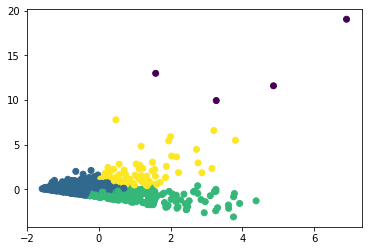

In [28]:
# wizualizacja klasteryzacji hierarchiczna 'cut_tree'
plt.scatter(x_pca.c1, x_pca.c2, c = x_pca['Hier'])
# widać 3 wyraźne klastry, czwarty jest 'naciągany'

In [29]:
# KLASTERYZACJA DBSCAN

In [30]:
from sklearn.cluster import DBSCAN
model_DBSCAN = DBSCAN(eps = 0.3, min_samples=4, n_jobs=-1).fit(x_pca.iloc[:,0:2])
x_pca['DBSCAN'] = model_DBSCAN.labels_

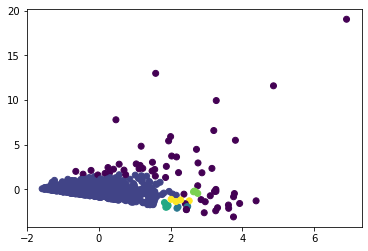

In [31]:
plt.scatter(x_pca.c1, x_pca.c2, c=x_pca['DBSCAN'])
# w DBSCAN podział na 4 klastry nie jest wyraźny

In [32]:
# DBSCAN bez minimalnej liczby klastrów
model_DBSCAN = DBSCAN(eps = 0.3, min_samples=30, leaf_size=60).fit(x_pca.iloc[:,0:2])
x_pca['DBSCAN'] = model_DBSCAN.labels_

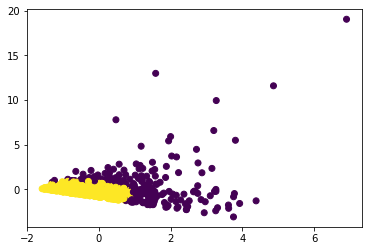

In [33]:
plt.scatter(x_pca.c1, x_pca.c2, c=x_pca['DBSCAN'])
# DBSCAN wydzielił 2 wyraźne klastry

In [34]:
# KLASTERYZACJA K-MEANS

In [35]:
model_km = KMeans(n_clusters=4, max_iter=1000, random_state=42)
model_km.fit(x_pca.iloc[:,0:2])
x_pca['KMeans'] = model_km.labels_

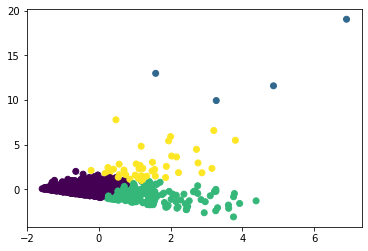

In [36]:
plt.scatter(x_pca.c1, x_pca.c2, c=x_pca['KMeans'])

Text(0.5, 1.0, 'K-means')

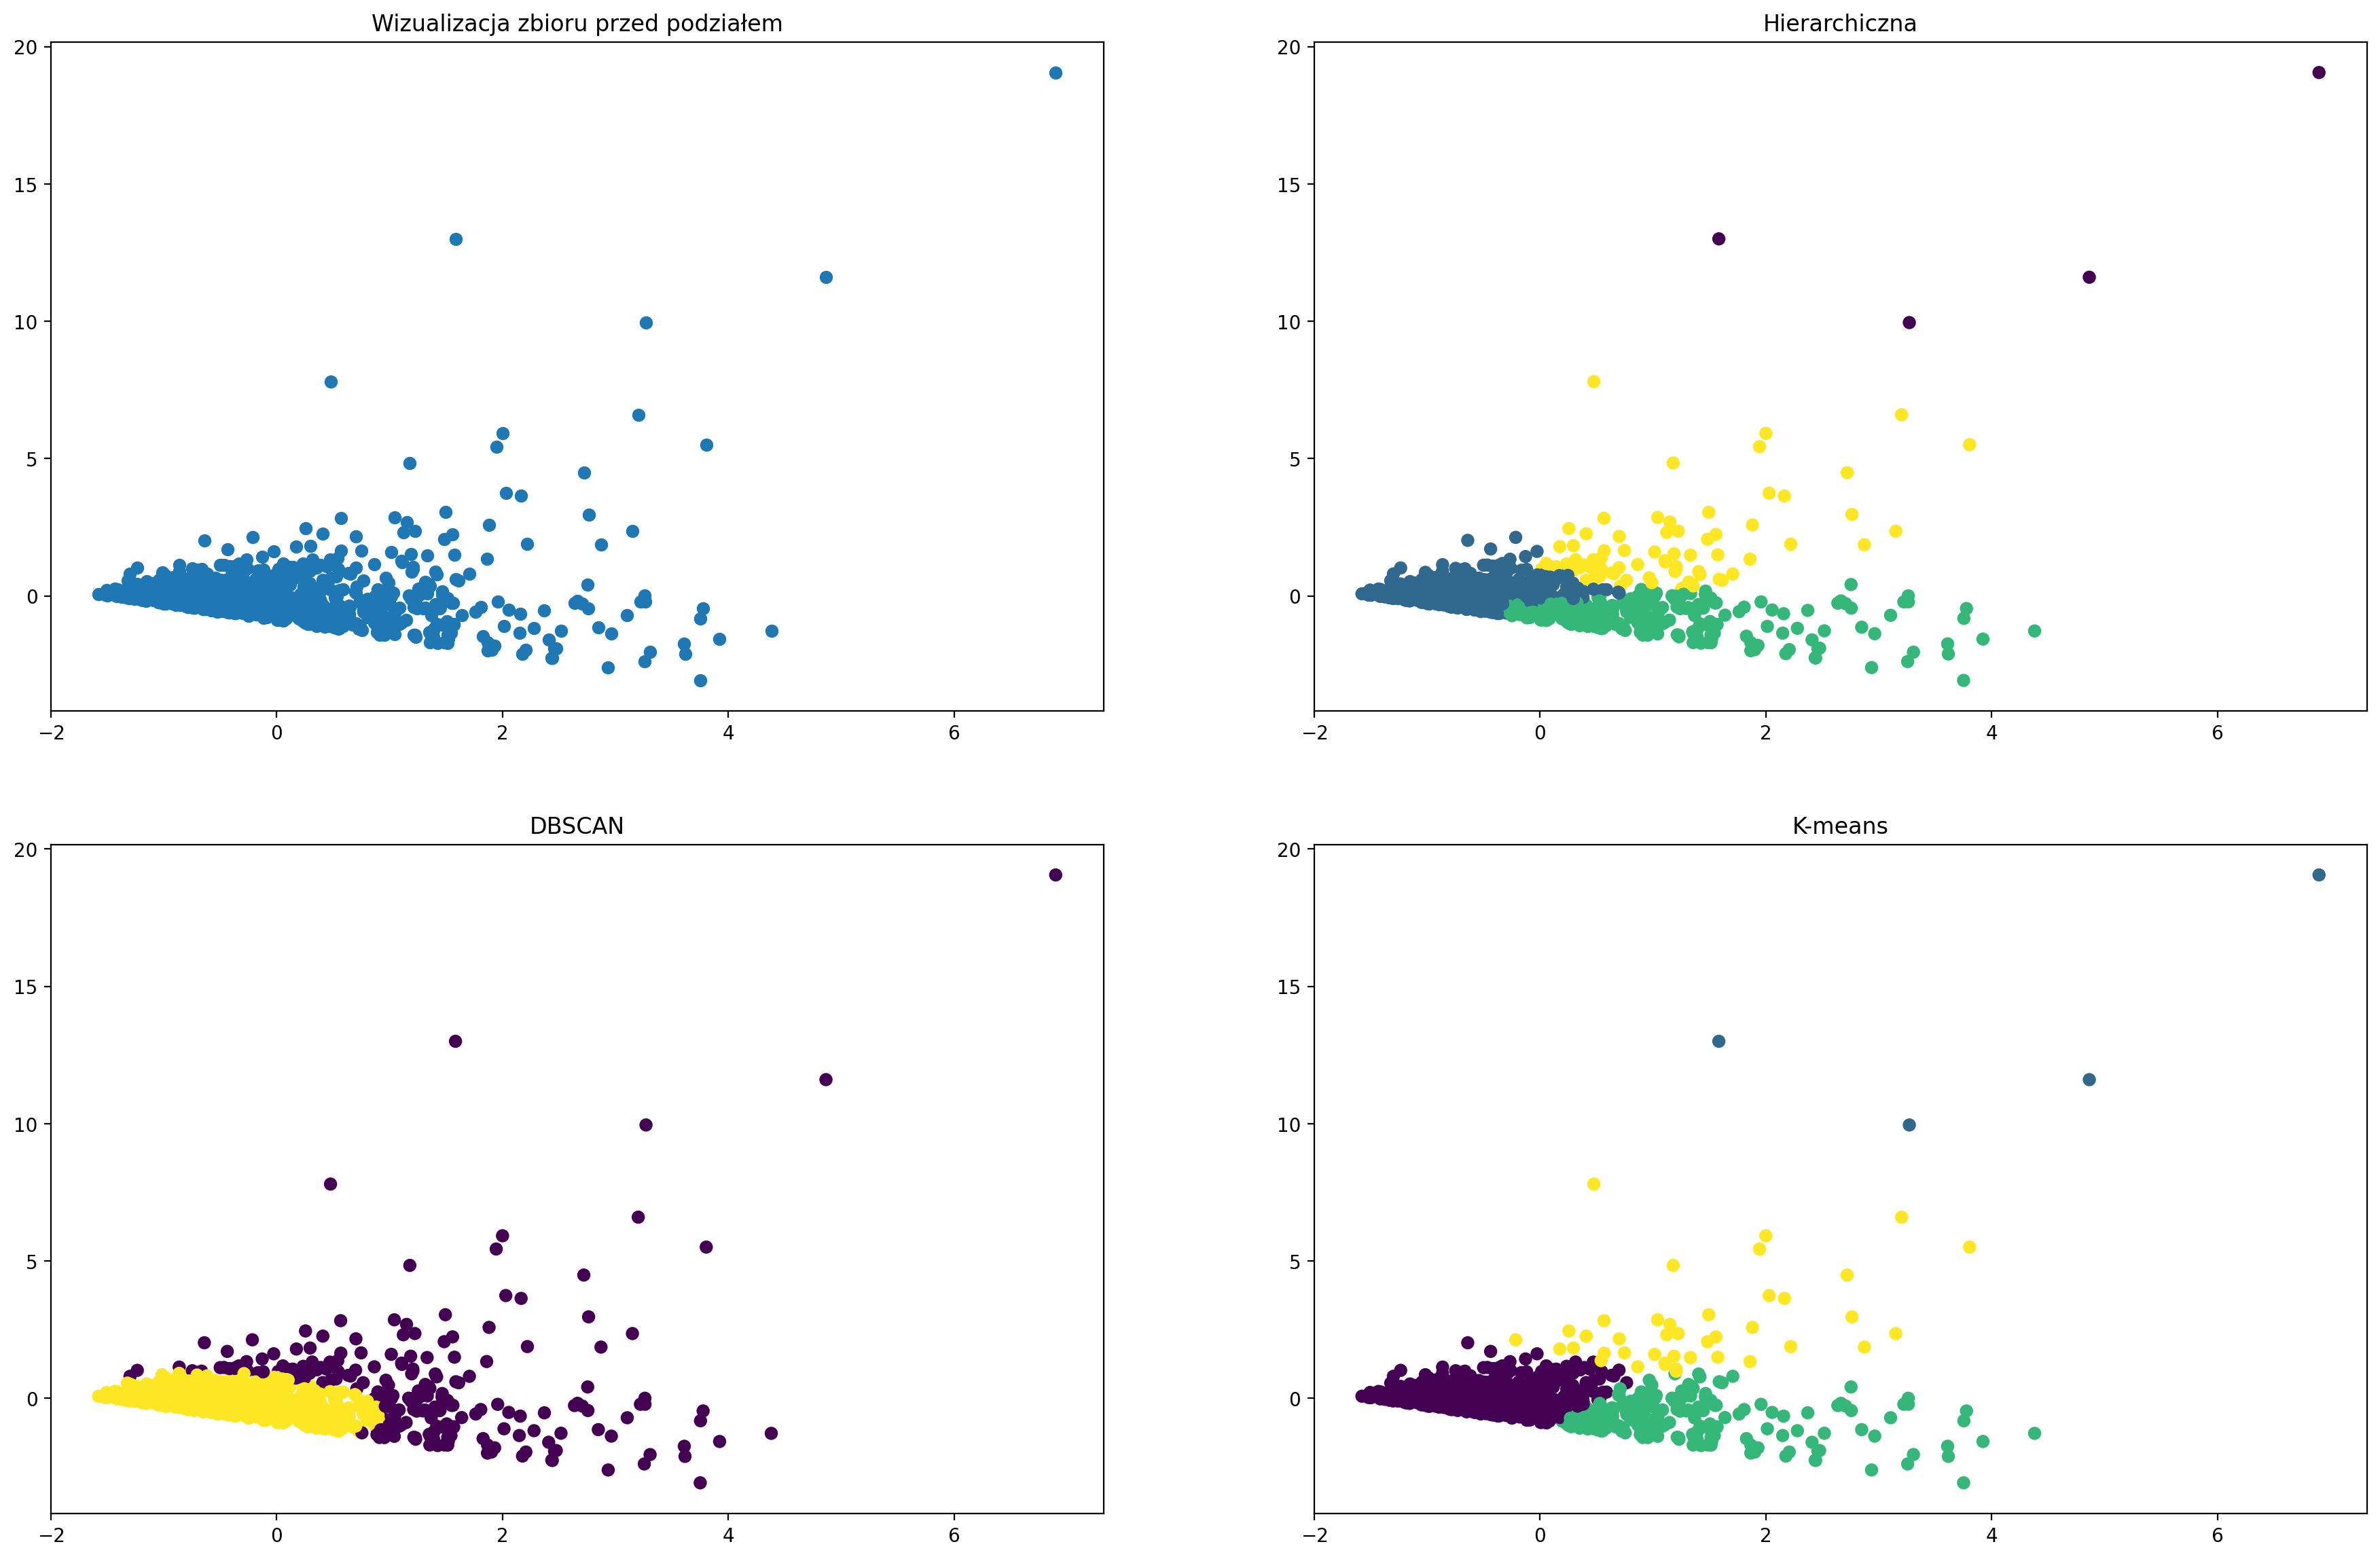

In [37]:
# Wizualizacja zbiorcza róznych metod klasteryzacji
plt.figure(figsize=(22,30), dpi=200)
plt.subplot(4,2,1)
plt.scatter(x_pca.c1, x_pca.c2)
plt.title('Wizualizacja zbioru przed podziałem')
plt.subplot(4,2,2)
plt.scatter(x_pca.c1, x_pca.c2, c = x_pca['Hier'])
plt.title('Hierarchiczna')
plt.subplot(4,2,3)
plt.scatter(x_pca.c1, x_pca.c2, c=x_pca['DBSCAN'])
plt.title('DBSCAN')
plt.subplot(4,2,4)
plt.scatter(x_pca.c1, x_pca.c2, c=x_pca['KMeans'])
plt.title('K-means')

In [38]:
# Klasteryzacja hierachiczna i K-means podziliły podobnie, DBSCAN wydzielił 2 wyrźne klastry

## KLASTERYZACJA K-MEANS NA PEŁNYM ZBIORZE

In [39]:
#K-means
#from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [40]:
#skalowanie całego zbioru
#from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_scaled = sc.fit_transform(x)

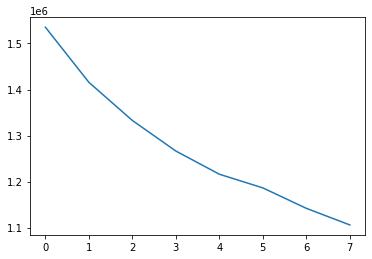

In [41]:
# określenie optymalnej liczby klastrów - metoda łokcia - elbow-curve
ssd = [] # Sum of squared distances
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(x_scaled)
    ssd.append(kmeans.inertia_) #Sum of squared distances   
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [42]:
# można ponowie przyjąć 4 klastry

In [43]:
##  U W A G A ##               Silhoette score liczy się ok 5 minut - można pominąc

In [44]:
# określenie optymalnej liczby klastrów - wskaźnik sylwetkowy
range_n_clusters = [2, 3, 4, 5, 6, 7]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(x_scaled)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    print(f'For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}')

For n_clusters=2, the silhouette score is 0.09332606678338365
For n_clusters=3, the silhouette score is 0.08464834165302633
For n_clusters=4, the silhouette score is 0.09663418767016191
For n_clusters=5, the silhouette score is 0.10240111424759527
For n_clusters=6, the silhouette score is 0.10180343400438266
For n_clusters=7, the silhouette score is 0.11265315896906064


In [45]:
# przyjmuję na podstawie metody łokcia założenie 4 klastrów
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state = 1)
kmeans.fit(x_scaled)

KMeans(max_iter=1000, n_clusters=4, random_state=1)

In [46]:
# dołączam klasteryzację k - means jako dodatkową kolumnę do zbioru
ldskrn['K-means_cluster_id'] = kmeans.labels_

In [47]:
#ldskrn['K-means_cluster_id'].unique()

<AxesSubplot:xlabel='K-means_cluster_id', ylabel='int_rate'>

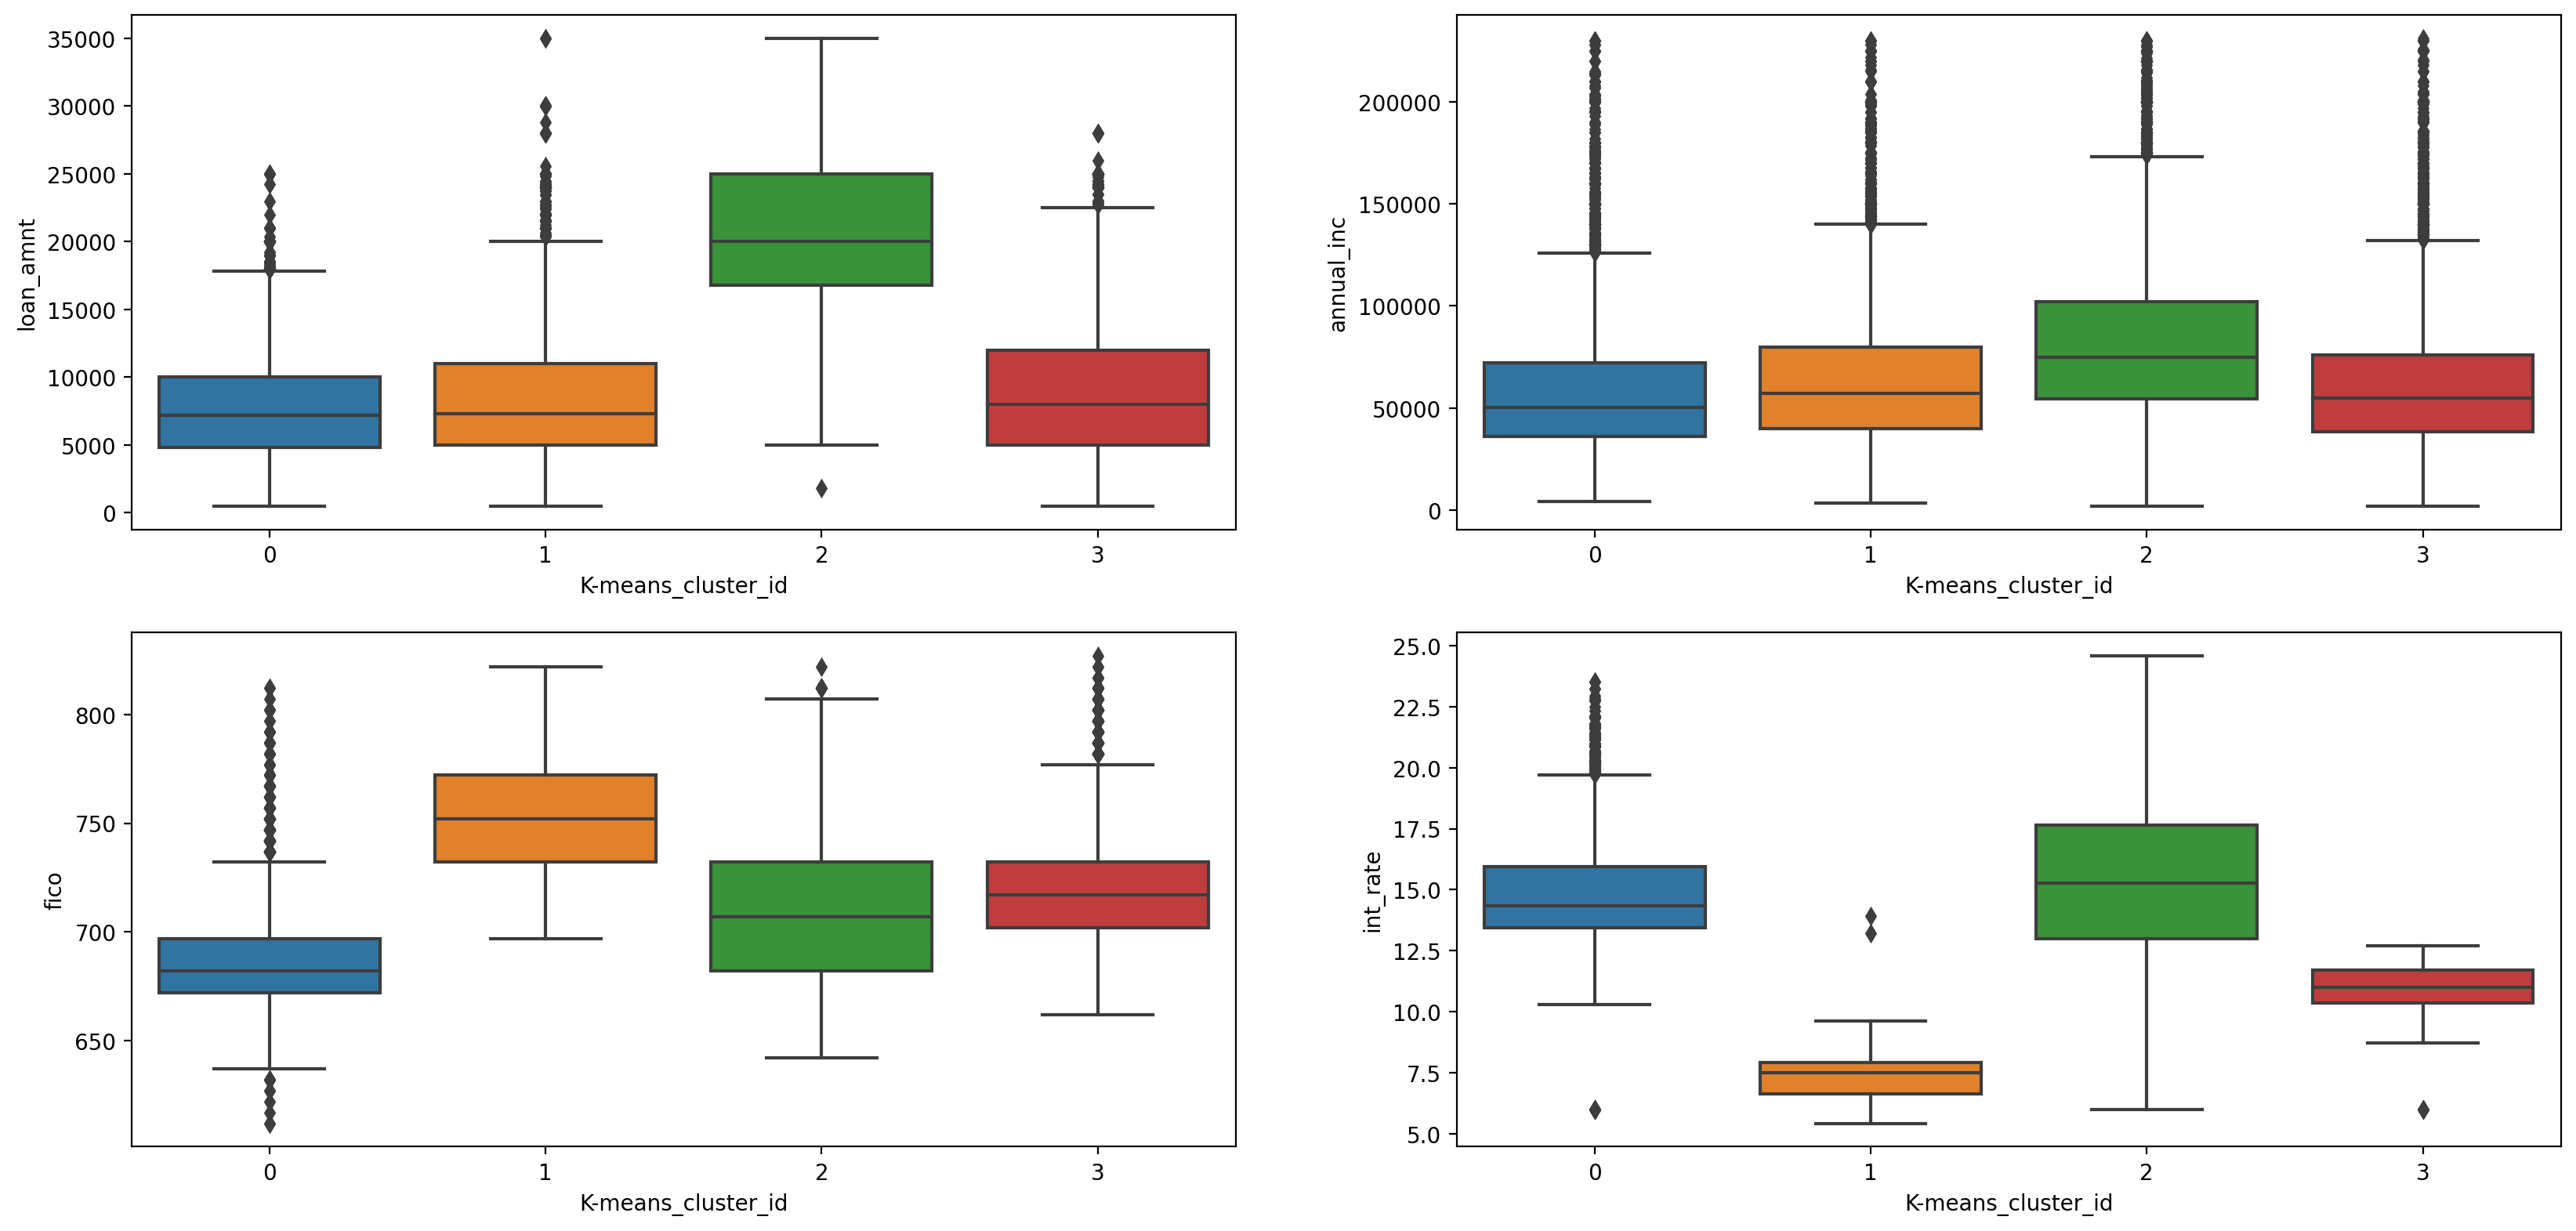

In [48]:
plt.figure(figsize=(20,20), dpi=200)
plt.subplot(4,2,1)
sns.boxplot(x='K-means_cluster_id', y='loan_amnt', data=ldskrn)
plt.subplot(4,2,2)
sns.boxplot(x='K-means_cluster_id', y='annual_inc', data=ldskrn)
plt.subplot(4,2,3)
sns.boxplot(x='K-means_cluster_id', y='fico', data=ldskrn)
plt.subplot(4,2,4)
sns.boxplot(x='K-means_cluster_id', y='int_rate', data=ldskrn)

In [49]:
# na wykresach wyróżnia się klaster o pożyczkobiorców z wyższą pożyczonej kwotą i większych dochodach
## oraz pożyczkobiorców który mieli wyższy ratimg fico i mnijesze oprocentowanie

# 4b TRENOWANIE MODELI

In [50]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, roc_auc_score, plot_roc_curve

In [51]:
# ponowny podział danych na etykiety i atrybuty - do danych zostały dołączone kolumny z klastrami
x = ldskrn.drop(['loan_status'], axis = 1)
y = ldskrn['loan_status']

In [52]:
ldskrn['loan_status'].value_counts()

1    35201
0     6294
Name: loan_status, dtype: int64

In [53]:
# Ponieważ klasy są niezblilansowane, zastosujemy oversampling syntetyczny SMOTE

In [54]:
#!pip install imblearn

In [55]:
from imblearn.combine import SMOTETomek
#Implementacja oversamplingu
smk = SMOTETomek(random_state=2020)
x_res, y_res = smk.fit_sample(x, y)

In [56]:
x.shape, y.shape, x_res.shape, y_res.shape

((41495, 38), (41495,), (67754, 38), (67754,))

In [57]:
# Split danych na zbiór treningowy i testowy
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=0)

In [58]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((54203, 38), (13551, 38), (54203,), (13551,))

In [59]:
# skalowanie
sc = StandardScaler()
x_scaled = sc.fit_transform(x_res)  # x_scaled będzie potrzebne w linijce 112
x_scaled_train = sc.fit_transform(x_train)
x_scaled_test = sc.transform(x_test)

In [60]:
x_scaled.shape, x_scaled_train.shape, x_scaled_test.shape, y.shape

((67754, 38), (54203, 38), (13551, 38), (41495,))

In [61]:
# utworę słownik gdzie będę zapisywał wyniki ROC poszczególnych modeli
summary_roc ={}

### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [64]:
dt_pred = dt.predict(x_test)

In [65]:
dt_auroc = roc_auc_score(dt_pred, y_test)
summary_roc['dt'] = dt_auroc.round(2)
print(f'AUROC: {dt_auroc}')

AUROC: 0.8472306799140984


In [66]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      6799
           1       0.86      0.83      0.84      6752

    accuracy                           0.85     13551
   macro avg       0.85      0.85      0.85     13551
weighted avg       0.85      0.85      0.85     13551



In [67]:
confusion_matrix(y_test, dt_pred)

array([[5867,  932],
       [1143, 5609]], dtype=int64)

In [68]:
# krzywa ROC
#plot_roc_curve(dt, x_test, y_test, color ='red')

### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestClassifier()

In [71]:
rf_pred = rf.predict(x_test)

In [72]:
rf_auroc = roc_auc_score(rf_pred, y_test)
summary_roc['rf']= rf_auroc.round(2)
print(f'AUROC: {rf_auroc}')

AUROC: 0.9127295249388717


In [73]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      6799
           1       0.86      0.97      0.91      6752

    accuracy                           0.91     13551
   macro avg       0.91      0.91      0.91     13551
weighted avg       0.91      0.91      0.91     13551



In [74]:
confusion_matrix(y_test, rf_pred)

array([[5730, 1069],
       [ 203, 6549]], dtype=int64)

In [75]:
# krzywa ROC
#plot_roc_curve(rf, x_test, y_test, color ='green')

### K Nearest Neighbors (KNN) ze skalowaniem

In [76]:
from sklearn.neighbors import KNeighborsClassifier

In [77]:
knnsc = KNeighborsClassifier(n_neighbors=2)
knnsc.fit(x_scaled_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [78]:
knnsc_pred = knnsc.predict(x_scaled_test)

In [79]:
knnsc_auroc = roc_auc_score(knnsc_pred, y_test)
summary_roc['knnsc']= knnsc_auroc.round(2)
print(f'AUROC: {knnsc_auroc}')
print(summary_roc)

AUROC: 0.8177542834482727
{'dt': 0.85, 'rf': 0.91, 'knnsc': 0.82}


In [80]:
print(classification_report(y_test, knnsc_pred))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      6799
           1       0.88      0.70      0.78      6752

    accuracy                           0.80     13551
   macro avg       0.82      0.80      0.80     13551
weighted avg       0.82      0.80      0.80     13551



In [81]:
confusion_matrix(y_test, knnsc_pred)

array([[6172,  627],
       [2028, 4724]], dtype=int64)

In [82]:
# krzywa ROC
#plot_roc_curve(knnsc, x_scaled_test, y_test, color ='black')

### Bagging

In [83]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

In [84]:
bag = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
bag.fit(x_train, y_train)
bag_pred = bag.predict(x_test)

In [85]:
bag_auroc = roc_auc_score(bag_pred, y_test)
summary_roc['bag']= bag_auroc.round(2)
print(f'AUROC: {bag_auroc}')
print(summary_roc)

AUROC: 0.8866565714465466
{'dt': 0.85, 'rf': 0.91, 'knnsc': 0.82, 'bag': 0.89}


In [86]:
print(classification_report(y_test, bag_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      6799
           1       0.86      0.91      0.89      6752

    accuracy                           0.89     13551
   macro avg       0.89      0.89      0.89     13551
weighted avg       0.89      0.89      0.89     13551



In [87]:
confusion_matrix(y_test, bag_pred)

array([[5831,  968],
       [ 584, 6168]], dtype=int64)

### AdaBoost

In [88]:
from sklearn.ensemble import AdaBoostClassifier

In [89]:
ada = AdaBoostClassifier(random_state=1)
ada.fit(x_train, y_train)
ada_pred = ada.predict(x_test)

In [90]:
ada_auroc = roc_auc_score(ada_pred, y_test)
summary_roc['ada']= ada_auroc.round(2)
print(f'AUROC: {ada_auroc}')
print(summary_roc)

AUROC: 0.8822555970921635
{'dt': 0.85, 'rf': 0.91, 'knnsc': 0.82, 'bag': 0.89, 'ada': 0.88}


In [91]:
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      6799
           1       0.84      0.93      0.88      6752

    accuracy                           0.88     13551
   macro avg       0.88      0.88      0.88     13551
weighted avg       0.88      0.88      0.88     13551



In [92]:
confusion_matrix(y_test, ada_pred)

array([[5608, 1191],
       [ 463, 6289]], dtype=int64)

### GBC

In [93]:
from sklearn.ensemble import GradientBoostingClassifier

In [94]:
gbc = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
gbc.fit(x_train, y_train)
gbc_pred = gbc.predict(x_test)
#gbc_probs = gbc.predict_proba(x_test)          # alt ver: prawdpodobieństwo każdej z etykiet
#gbc_probs = gbc_probs[:,1]                     # alt ver: prawdopodobieństwo etykiety 1

In [95]:
gbc_auroc = roc_auc_score(gbc_pred, y_test)
#gbc_auroc = roc_auc_score(y_test,gbc_probs)   # alt ver
summary_roc['gbc']= gbc_auroc.round(2)
print(f'AUROC: {gbc_auroc}')
print(summary_roc)

AUROC: 0.8251802146054666
{'dt': 0.85, 'rf': 0.91, 'knnsc': 0.82, 'bag': 0.89, 'ada': 0.88, 'gbc': 0.83}


In [96]:
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      6799
           1       0.81      0.85      0.83      6752

    accuracy                           0.82     13551
   macro avg       0.83      0.82      0.82     13551
weighted avg       0.83      0.82      0.82     13551



In [97]:
confusion_matrix(y_test, gbc_pred)

array([[5463, 1336],
       [1041, 5711]], dtype=int64)

# 4c MODELOWANIE Z KOMPRESJĄ PCA

### KOMPRESJA PCA

In [98]:
#from sklearn.decomposition import PCA

In [99]:
pca = PCA(random_state = 1) 

In [100]:
x_scaled_pca = pca.fit_transform(x_scaled)
#x_pca = pca.fit_transform(x)

In [101]:
x_scaled_pca_df = pd.DataFrame(data=x_scaled_pca)
#x_pca_df = pd.DataFrame(data=x_pca)

In [102]:
x_scaled_pca_df.shape
#x_pca_df.shape

(67754, 38)

In [103]:
np.sum(pca.explained_variance_ratio_)

0.9999999999999997

In [104]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.11232643, 0.19333435, 0.25221538, 0.29962636, 0.34184119,
       0.3801072 , 0.41325143, 0.44389361, 0.47392318, 0.50317264,
       0.53118399, 0.55877961, 0.58614592, 0.61332592, 0.64018788,
       0.66694529, 0.69360817, 0.72014771, 0.74661876, 0.77296789,
       0.7990901 , 0.82502476, 0.85069724, 0.87572912, 0.89766363,
       0.91685482, 0.93212506, 0.94709978, 0.95918545, 0.97042882,
       0.97793564, 0.98347064, 0.98778367, 0.99174432, 0.9950193 ,
       0.99812748, 0.99960899, 1.        ])

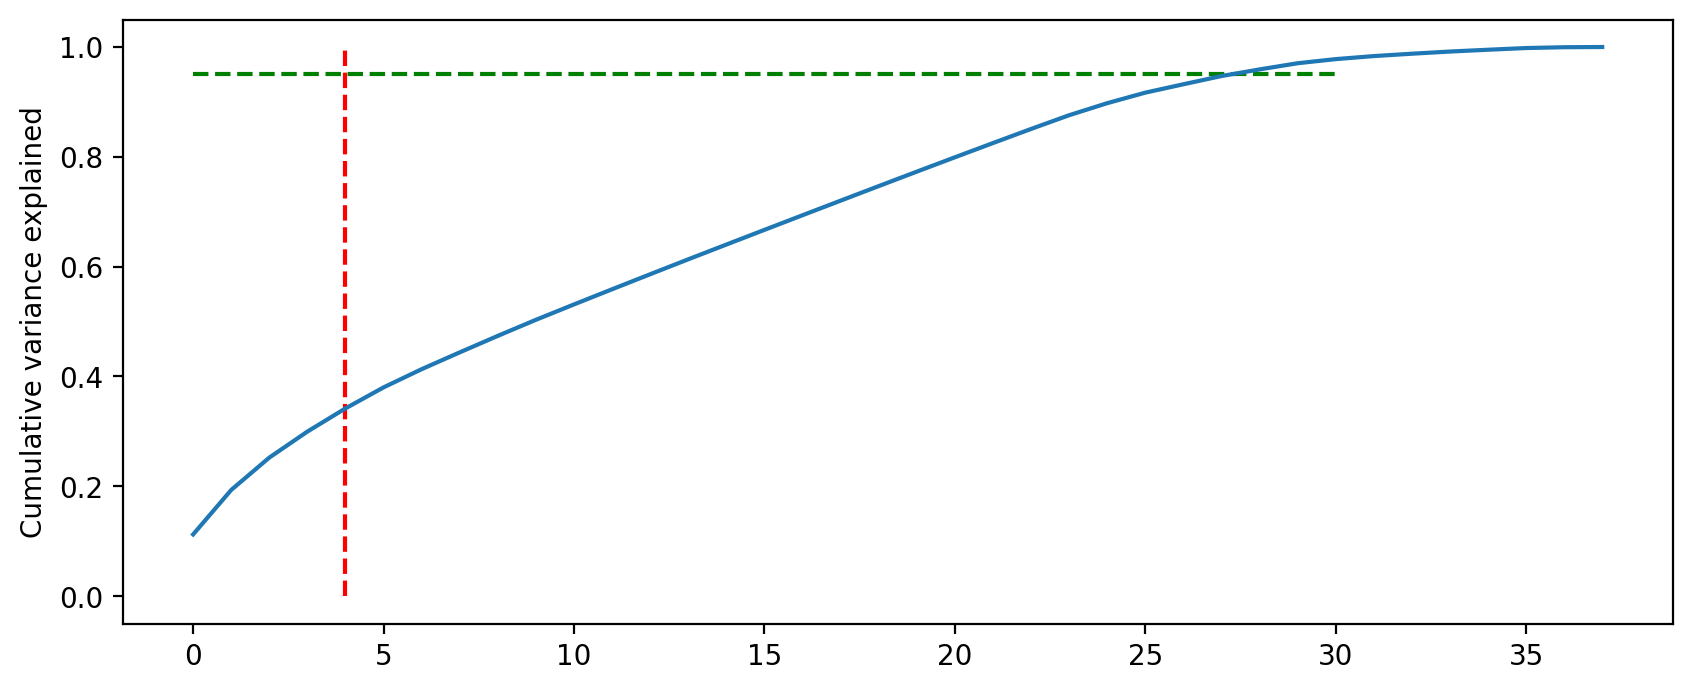

In [105]:
fig = plt.figure(figsize=[10,4],dpi=200)
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [106]:
# zakładamy, że 28 kolumn pokryje nam 95 % zmienności
pca = PCA(n_components = 28, random_state = 1)

In [107]:
x_scaled_pca = pca.fit_transform(x_scaled)
x_scaled_pca_df = pd.DataFrame(data=x_scaled_pca)

In [108]:
np.sum(pca.explained_variance_ratio_)

0.9470997775985794

### SPRAWDZENIE DZIAŁANIA MODELI NA DANYCH SKOMPRESOWANYCH (PCA)

In [109]:
x_scaled_pca_train, x_scaled_pca_test, y_train, y_test = train_test_split(x_scaled_pca_df,y_res, test_size=0.20)

In [110]:
# wybieram najlepsze 3 modele

In [111]:
# RANDOM FOREST WITH PCA
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_scaled_pca_train, y_train)
rf_pred_pca = rf.predict(x_scaled_pca_test)
rf_auroc_pca = roc_auc_score(rf_pred_pca, y_test)
confusion_matrix(y_test, rf_pred_pca)
print(classification_report(y_test, rf_pred_pca))
print(f'RF AUROC: {rf_auroc.round(2)}, RF AUROC z PCA {rf_auroc_pca.round(2)}' )

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      6765
           1       0.84      0.95      0.89      6786

    accuracy                           0.89     13551
   macro avg       0.89      0.89      0.89     13551
weighted avg       0.89      0.89      0.89     13551

RF AUROC: 0.91, RF AUROC z PCA 0.89


In [112]:
# BAGGING WITH PCA
bag = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
bag.fit(x_scaled_pca_train, y_train)
bag_pred_pca = bag.predict(x_scaled_pca_test)
bag_auroc_pca = roc_auc_score(bag_pred_pca, y_test)
print(classification_report(y_test, bag_pred_pca))
print(f'BAG AUROC: {ada_auroc.round(2)}, BAG AUROC z PCA {bag_auroc_pca.round(2)}')

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6765
           1       0.84      0.87      0.86      6786

    accuracy                           0.85     13551
   macro avg       0.85      0.85      0.85     13551
weighted avg       0.85      0.85      0.85     13551

BAG AUROC: 0.88, BAG AUROC z PCA 0.85


In [113]:
# ADA BOOST WITH PCA
ada = AdaBoostClassifier(random_state=1)
ada.fit(x_scaled_pca_train, y_train)
ada_pred_pca = ada.predict(x_scaled_pca_test)
ada_auroc_pca = roc_auc_score(ada_pred_pca, y_test)
print(classification_report(y_test, ada_pred_pca))
print(f'ADA AUROC: {ada_auroc.round(2)}, ADA AUROC z PCA {ada_auroc_pca.round(2)}')

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      6765
           1       0.82      0.84      0.83      6786

    accuracy                           0.82     13551
   macro avg       0.82      0.82      0.82     13551
weighted avg       0.82      0.82      0.82     13551

ADA AUROC: 0.88, ADA AUROC z PCA 0.82


# 4d FINALNY MODEL, KROSS WALIDACJA

In [114]:
# dołączam pipeline aby zapobiec przeciekowi danych na etapie kross walidacji
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict

In [115]:
# cross validacja - puszczam modele z cross walidacją i k-4.
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
# cv = KFold(n_splits=4, shuffle=True, random_state=42)

In [117]:
# RANDOM FOREST
rf_pipeline = make_pipeline(RandomForestClassifier(random_state=42, max_depth=10))
score = cross_val_score(rf_pipeline, x_scaled_pca_df, y_res, cv= kf, scoring="roc_auc")
print(f'Scores for each fold are: {score}')
print(f'Average score: {score.mean().round(3)}')

Scores for each fold are: [0.92375712 0.92793906 0.92241537 0.92385276]
Average score: 0.924


In [118]:
# BAGGING
bag_pipeline = make_pipeline(BaggingClassifier(tree.DecisionTreeClassifier(random_state=1)))
score = cross_val_score(bag_pipeline, x_scaled_pca_df, y_res, cv= kf, scoring="roc_auc")
print(f'Scores for each fold are: {score}')
print(f'Average score: {score.mean().round(3)}')

Scores for each fold are: [0.91634428 0.92100829 0.91433375 0.914166  ]
Average score: 0.916


In [119]:
# ADABOOST
ada_pipeline = make_pipeline(AdaBoostClassifier(random_state=1))
score = cross_val_score(ada_pipeline, x_scaled_pca_df, y_res, cv= kf, scoring="roc_auc")
print(f'Scores for each fold are: {score}')
print(f'Average score: {score.mean().round(3)}')

Scores for each fold are: [0.89979094 0.90132908 0.8974099  0.90164153]
Average score: 0.9


### Finalny model - RANDOM FOREST - optymalny pod kątem auroc jak i F1 score

# KONIEC PROJEKTU